In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


***Import Libraries***

In [3]:
import os
import glob
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
import numpy as np

np.random.seed(42)
tf.random.set_seed(42)

***Load Training and Testing Brain Tumour Images***

In [5]:
train_path = '/content/drive/MyDrive/MSC Project/Brain Tumor MRI Dataset/Training_project'
test_path = '/content/drive/MyDrive/MSC Project/Brain Tumor MRI Dataset/Testing_project'

***Count the number of MRI Images in the training and testing set***

In [6]:
def get_number(path):
  if not os.path.exists(path):
    return 0
  count = 0

  for current_path, dirs, files in os.walk(path):
    for dr in dirs:
      count += len(glob.glob(os.path.join(current_path,dr + "/*")))
  return count

In [7]:
training_images = get_number(train_path)
testing_images = get_number(test_path)
num_classes = len(glob.glob(train_path + "/*"))

print("Number of classes is", num_classes)
print("Number of training samples is", training_images)
print("Number of testing samples is", testing_images)

Number of classes is 4
Number of training samples is 5752
Number of testing samples is 1311


***Data Augmentation***

In [8]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest',
    )

test_datagen = ImageDataGenerator(
    rescale=1./255
    )

In [9]:
img_width, img_height = 150, 150
input_shape = (img_width, img_height, 3)
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical')

test_generator = test_datagen.flow_from_directory(
    test_path,
    shuffle = False,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical')

Found 5752 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


***Build CNN Model for Brain Tumour Classification***

In [10]:
model = Sequential()

# Convolutional layers with increased number of filters and adjusted kernel sizes
model.add(Conv2D(32, (3, 3), input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten layer to transition from convolutional to dense layers
model.add(Flatten())

# Fully connected (dense) layers with dropout for regularization
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization

# Output layer with 'num_classes' neurons and softmax activation for classification
model.add(Dense(num_classes, activation='softmax'))

# Compile the model with an adjusted learning rate
#optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,454,660 (13.18 MB)

 Trainable params: 3,454,660 (13.18 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
best_model_path = '/content/drive/MyDrive/MSC Project/best_cnn_model_new_test.keras'

# Early stopping callback
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 3, restore_best_weights = True, verbose = 1)

# Model checkpoint callback to save the best model
model_checkpoint = ModelCheckpoint(best_model_path, monitor = 'val_accuracy', save_best_only = True, verbose = 1)

In [12]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    validation_data = test_generator,
    validation_steps = test_generator.samples // test_generator.batch_size,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping, model_checkpoint]  # Pass both callbacks
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.4218 - loss: 1.1723 
Epoch 1: val_accuracy improved from -inf to 0.59062, saving model to /content/drive/MyDrive/MSC Project/best_cnn_model_new_test.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 1896s 10s/step - accuracy: 0.4225 - loss: 1.1713 - val_accuracy: 0.5906 - val_loss: 1.0299
Epoch 2/100
  1/179 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.6250 - loss: 0.9338

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy improved from 0.59062 to 0.90323, saving model to /content/drive/MyDrive/MSC Project/best_cnn_model_new_test.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.6250 - loss: 0.9338 - val_accuracy: 0.9032 - val_loss: 0.5484
Epoch 3/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.6871 - loss: 0.7823
Epoch 3: val_accuracy did not improve from 0.90323
179/179 ━━━━━━━━━━━━━━━━━━━━ 99s 331ms/step - accuracy: 0.6872 - loss: 0.7821 - val_accuracy: 0.5805 - val_loss: 1.2110
Epoch 4/100
  1/179 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.6562 - loss: 0.7367
Epoch 4: val_accuracy did not improve from 0.90323
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - accuracy: 0.6562 - loss: 0.7367 - val_accuracy: 0.7097 - val_loss: 0.8171
Epoch 5/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.7303 - loss: 0.6703
Epoch 5: val_accuracy did not improve from 0.90323
179/179 ━━━━━━━━━━━━━━━━━━━━ 61s 331ms/step - accuracy: 0.7304 - loss: 0.6702 - val_a

In [13]:
# Load the best model
best_model = tf.keras.models.load_model(best_model_path)

In [14]:
# Evaluate the best model
test_loss, test_accuracy = best_model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy}')

41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 0.4255 - loss: 1.4325
Test Accuracy: 0.5888634920120239


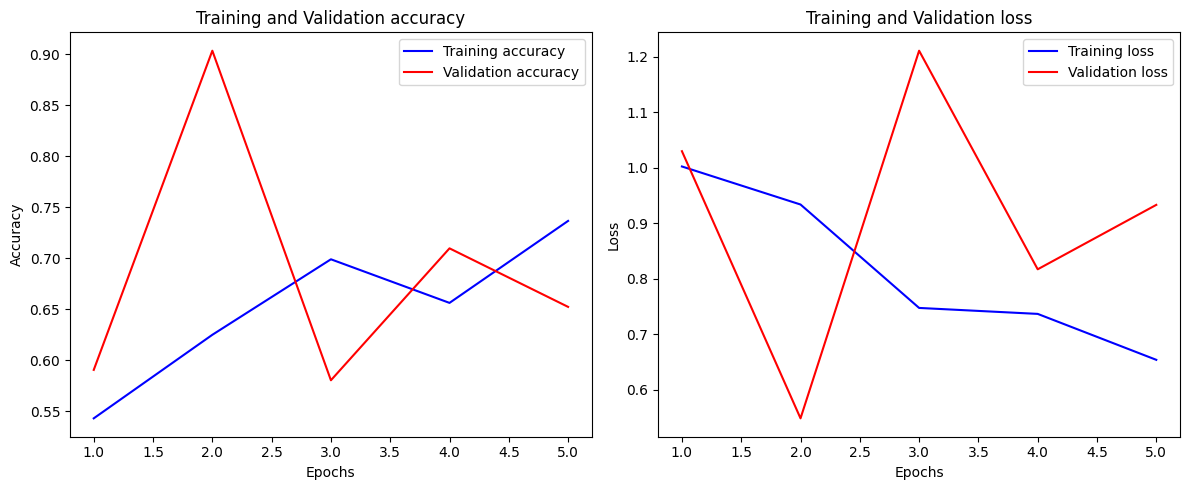

In [15]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plotting Training and Validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)  # (rows, columns, panel number)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Training and Validation loss
plt.subplot(1, 2, 2)  # (rows, columns, panel number)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()  # Adjust the layout for better appearance
plt.show()

In [16]:
Classes = ['Glioma', 'Meningioma', 'No Tumour', 'Pituitary']

In [17]:
from sklearn.metrics import classification_report,confusion_matrix
y_test = test_generator.classes

# predicting our model with test dataset i.e. unseen dataset
pred = model.predict(test_generator, testing_images//batch_size+1,verbose=1,).argmax(axis=1)
#print(y_test)
print(pred)
#Classification report of every label
print(classification_report(y_test, pred, target_names = Classes))

41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step
[2 0 0 ... 3 3 2]
              precision    recall  f1-score   support

      Glioma       0.81      0.31      0.45       300
  Meningioma       0.49      0.27      0.35       306
   No Tumour       0.57      0.93      0.71       405
   Pituitary       0.60      0.73      0.66       300

    accuracy                           0.59      1311
   macro avg       0.62      0.56      0.54      1311
weighted avg       0.61      0.59      0.55      1311



In [ ]:
correct = 0
incorrect = 0
for i in range(len(y_test)):

    #print("Test Sample is: ", y_test[i], "while predicted sample is: ", pred[i])

    if y_test[i] != pred[i]:
        incorrect += 1
    else:
        correct += 1

print('Total number of test cases', ((len(y_test))))
print('Number of correct predictions', correct)
print('Number of incorrect predictions', incorrect)

***Plot Confusion Matrix***

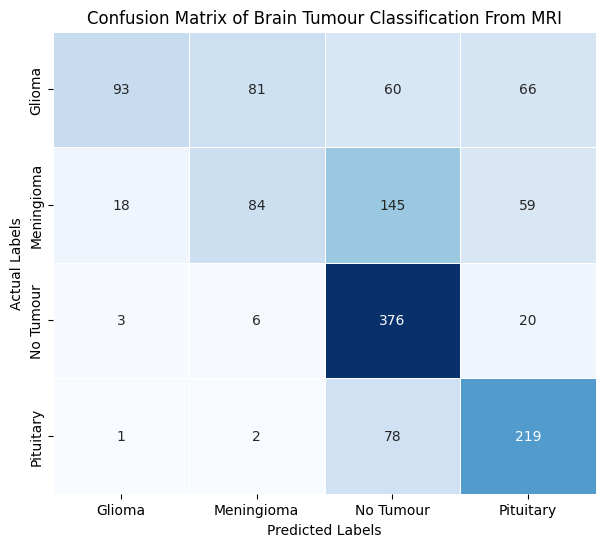

In [19]:
import pandas as pd
import seaborn as sn

# Create a confusion matrix
conf_mat = confusion_matrix(y_test, pred)

# Create a DataFrame from the confusion matrix
conf_df = pd.DataFrame(conf_mat, columns = Classes, index = Classes)

# Plot the confusion matrix using seaborn with annotated actual and predicted labels
plt.figure(figsize = (7, 6))
plt.title('Confusion Matrix of Brain Tumour Classification From MRI')
sn.heatmap(conf_df, fmt = "d", cmap = "Blues", annot = True, cbar = False, linewidths = .5)

# Add x and y axis labels
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')

plt.show()